# Housing price modeling

Elias Eskelinen, Vili Niemelä, Matti Aalto and Jarkko Komulainen

---

In this project, a model to predict the house-prices of the New York metropolitan areas in U.S. is implemented.

## Data onboarding

Import libraries and set figures directory

In [66]:
import os
import numpy as np
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns

figs_dir =  "./figures" if os.path.isdir('figures') else ""

Fetch the data from the kaggle API (saved as a local file)

In [51]:
# Fetch the latest version of the dataset from kaggle
data_dir = kagglehub.dataset_download("shengkunwang/housets-dataset")
data_path = os.path.join(data_dir, "HouseTS.csv")

Load the data from the local file

In [52]:
data = pd.read_csv(data_path)
print(data.shape)
print(data.head())
print(data.info())

(884092, 39)
         date  median_sale_price  median_list_price  median_ppsf  \
0  2012-03-31            46550.0           217450.0    31.813674   
1  2012-04-30            61870.0           245000.0    40.723982   
2  2012-05-31           125500.0           217450.0    63.913043   
3  2012-06-30           153000.0           189900.0    81.598080   
4  2012-07-31           165500.0           154000.0    81.598080   

   median_list_ppsf  homes_sold  pending_sales  new_listings  inventory  \
0        110.183666        14.0           23.0          44.0       64.0   
1        130.528256        22.0           29.0          56.0       69.0   
2        119.919216        24.0           40.0          63.0       60.0   
3        105.617353        34.0           46.0          50.0       57.0   
4         83.921175        39.0           49.0          42.0       50.0   

   median_dom  ...  Total Housing Units  Median Rent  Median Home Value  \
0        59.5  ...               2677.0        710.0

Format `date` column as `datetime` and set the `date` column as the dataset index

In [ ]:
# date to index
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

Keeping only the cities: New York-Newark-Jersey City, Chicago-Naperville-Elgin, Los Angeles-Long Beach-Anaheim, Philadelphia-Camden-Wilmington, and DC_Metro:

In [66]:
keep_cities = ["New York-Newark-Jersey City", "Chicago-Naperville-Elgin", "Los Angeles-Long Beach-Anaheim", "Philadelphia-Camden-Wilmington", "DC_Metro"]
data = data[data['city_full'].isin(keep_cities)]

data["city_full"].unique()

array(['Chicago-Naperville-Elgin', 'DC_Metro',
       'Los Angeles-Long Beach-Anaheim', 'New York-Newark-Jersey City',
       'Philadelphia-Camden-Wilmington'], dtype=object)

---

## Data visualization and exploratory analysis

The time-series dataset consists of 884092 samples with 39 variables. The samples are monthly observations of housingThe predicted variable is `price`; the predictors are all numerical data, except for the `date` variable and the categorical variables `city` and `city_full`. 

In [54]:
# Quick summary
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 884092 entries, 2012-03-31 to 2023-12-31
Data columns (total 38 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   median_sale_price             884092 non-null  float64
 1   median_list_price             884092 non-null  float64
 2   median_ppsf                   884092 non-null  float64
 3   median_list_ppsf              884092 non-null  float64
 4   homes_sold                    884092 non-null  float64
 5   pending_sales                 884092 non-null  float64
 6   new_listings                  884092 non-null  float64
 7   inventory                     884092 non-null  float64
 8   median_dom                    884092 non-null  float64
 9   avg_sale_to_list              884092 non-null  float64
 10  sold_above_list               884092 non-null  float64
 11  off_market_in_two_weeks       884092 non-null  float64
 12  city                        

In [57]:
print(data['city'].unique(), len(data['city'].unique()))
print(data['city_full'].unique(), len(data['city_full'].unique()))
print(len(data['zipcode']))

data[data['city']=="ATL"]

['ATL' 'ATX' 'BOS' 'BWI' 'CHI' 'CIN' 'CLT' 'DAL' 'DC' 'DEN' 'DET' 'HOU'
 'LA' 'LV' 'MIA' 'MSP' 'NY' 'ORL' 'PDX' 'PGH' 'PHL' 'PHX' 'RIV' 'SA' 'SAC'
 'SD' 'SEA' 'SF' 'STL' 'TPA'] 30
['Atlanta-Sandy Springs-Alpharetta' 'Austin-Round Rock-Georgetown'
 'Boston-Cambridge-Newton' 'Baltimore-Columbia-Towson'
 'Chicago-Naperville-Elgin' 'Cincinnati' 'Charlotte-Concord-Gastonia'
 'Dallas-Fort Worth-Arlington' 'DC_Metro' 'Denver-Aurora-Lakewood'
 'Detroit-Warren-Dearborn' 'Houston-The Woodlands-Sugar Land'
 'Los Angeles-Long Beach-Anaheim' 'Las Vegas-Henderson-Paradise'
 'Miami-Fort Lauderdale-Pompano Beach' 'Minneapolis-St. Paul-Bloomington'
 'New York-Newark-Jersey City' 'Orlando-Kissimmee-Sanford'
 'Portland-Vancouver-Hillsboro' 'Pittsburgh'
 'Philadelphia-Camden-Wilmington' 'Phoenix-Mesa-Chandler'
 'Riverside-San Bernardino-Ontario' 'San Antonio-New Braunfels'
 'Sacramento-Roseville-Folsom' 'San Diego-Chula Vista-Carlsbad'
 'Seattle-Tacoma-Bellevue' 'San Francisco-Oakland-Berkeley' 'St. Louis

,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,median_dom,avg_sale_to_list,...,Total Housing Units,Median Rent,Median Home Value,Total Labor Force,Unemployed Population,Total School Age Population,Total School Enrollment,Median Commute Time,price,city_full
date,,,,,,,,,,,,,,,,,,,,,
2012-03-31,46550.0,217450.0,31.813674,110.183666,14.0,23.0,44.0,64.0,59.5,0.943662,...,2677.0,710.0,279500.0,3171.0,460.0,5408.0,5408.0,2492.0,200773.999557,Atlanta-Sandy Springs-Alpharetta
2012-04-30,61870.0,245000.0,40.723982,130.528256,22.0,29.0,56.0,69.0,89.5,0.946642,...,2677.0,710.0,279500.0,3171.0,460.0,5408.0,5408.0,2492.0,202421.064584,Atlanta-Sandy Springs-Alpharetta
2012-05-31,125500.0,217450.0,63.913043,119.919216,24.0,40.0,63.0,60.0,144.5,0.955624,...,2677.0,710.0,279500.0,3171.0,460.0,5408.0,5408.0,2492.0,202681.309539,Atlanta-Sandy Springs-Alpharetta
2012-06-30,153000.0,189900.0,81.598080,105.617353,34.0,46.0,50.0,57.0,126.0,0.970608,...,2677.0,710.0,279500.0,3171.0,460.0,5408.0,5408.0,2492.0,202998.603897,Atlanta-Sandy Springs-Alpharetta
2012-07-31,165500.0,154000.0,81.598080,83.921175,39.0,49.0,42.0,50.0,80.0,0.982105,...,2677.0,710.0,279500.0,3171.0,460.0,5408.0,5408.0,2492.0,203781.903446,Atlanta-Sandy Springs-Alpharetta
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,150000.0,180000.0,104.477612,97.338076,5.0,4.0,10.0,7.0,17.0,0.926795,...,1094.0,722.0,138000.0,974.0,17.0,2299.0,2299.0,879.0,176889.200198,Atlanta-Sandy Springs-Alpharetta
2023-09-30,140000.0,159950.0,89.962121,88.645418,3.0,3.0,8.0,5.0,10.0,0.906891,...,1094.0,722.0,138000.0,974.0,17.0,2299.0,2299.0,879.0,176989.845702,Atlanta-Sandy Springs-Alpharetta
2023-10-31,136000.0,169950.0,75.166630,79.488636,2.0,4.0,6.0,7.0,91.5,0.836111,...,1094.0,722.0,138000.0,974.0,17.0,2299.0,2299.0,879.0,177274.045213,Atlanta-Sandy Springs-Alpharetta


Next, check for missing temporal datapoints (for each city)

In [78]:
city_data= data[data['city_full'] == 'Philadelphia-Camden-Wilmington']
#city_data['date'] = city_data.index
len(city_data['zipcode'].unique())

#city_data.groupby('date')

334

In [ ]:
import seaborn as sns

# Correlation matrices
data_corr = data.iloc[:,1:].corr()
plt.figure(figsize=(18, 15))
sns.heatmap(data_corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.savefig(os.path.join(figs_dir, f"correlation_matrix.png"), dpi=300)
plt.show()

# Histograms
data.hist(figsize=(20, 15))
plt.tight_layout()
plt.savefig(os.path.join(figs_dir, f"variable_distributions.png"), dpi=300)
plt.show()

ValueError: could not convert string to float: 'ATL'

---

## Time-series decomposition analysis

For decomposition we use statsmodels Seasonal-Trend decomposition which decomposes time series into trend, seasonal, and residual. The method requires that the season length has to be defined.

Defining the corresponding hypreparameters by visually studying the price time series:

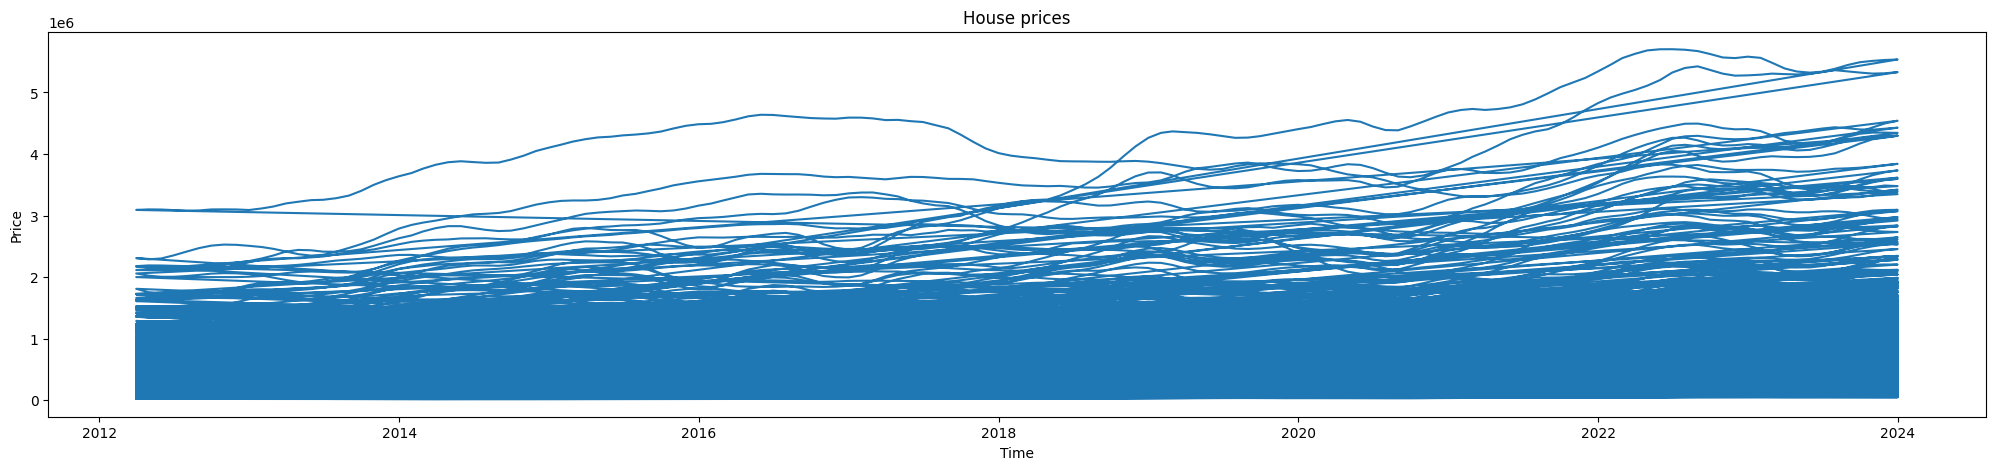

In [56]:
plt.figure(figsize=(25,5))
plt.plot(data["price"])
plt.title("House prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()


In [ ]:
plt.figure(figsize=(25,5))
plt.plot(data.iloc["price"]) #20:10000,
plt.title("House prices zoomed")
plt.xlabel("Time")
plt.ylabel("Price")

plt.figure(figsize=(25,5))
plt.plot(data["price"][400000:402000])
plt.title("House prices zoomed")
plt.xlabel("Time")
plt.ylabel("Price")

plt.figure(figsize=(25,5))
plt.plot(data["price"][800000:802000])
plt.title("House prices zoomed")
plt.xlabel("Time")
plt.ylabel("Price")

plt.figure(figsize=(25,5))
plt.plot(data["price"][800020:800200])
plt.plot(data.index[800028], data["price"][800028], "*r", label="start of the season: t=800028")
plt.plot(data.index[800170], data["price"][800170], "*g", label="end of the season t=800170")
plt.title("House prices zoomed")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()

plt.show()

---

## Autocorrelation analysis

---

## Partitioning the time-series data